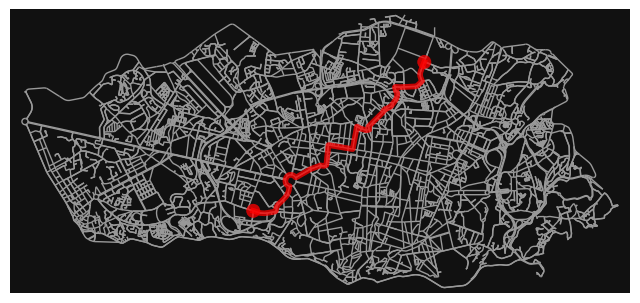

In [79]:
import osmnx as ox

place = "Porto, Portugal"
G = ox.graph_from_place(place, network_type="drive")

# find the shortest path (by distance)
# between these nodes then plot it
# Origin and destination nodes (Asprela and Campo Alegre)
orig, dest = 4523960189, 479183608

# find k-shortest path
routes = ox.k_shortest_paths(G, orig, dest, k=2, weight="length")
fig, ax = ox.plot_graph_routes(
    G, list(routes), route_colors="r",
    route_linewidth=4, node_size=0)

## SETUP
- Import dependencies
- load graph 
- set nodes for Asprela and Campo Alegre
- define functions

In [86]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd

# Set a seed for reproducibility
SEED = 42
random.seed(SEED)

# Load the graph for Porto, Portugal
place = "Porto, Portugal"
G = ox.graph_from_place(place, network_type="drive")

# Origin and destination nodes (Asprela and Campo Alegre)
asprela, campoalegre = 4523960189, 479183608

# Function to compute distinct routes with edge penalization
def compute_distinct_routes(graph, source, target, num_routes, weight='length', penalty=1000):
    """
    Compute distinct routes by penalizing edges from previously found routes.
    
    Parameters:
        graph: NetworkX graph
        source: Starting node
        target: Ending node
        num_routes: Number of distinct routes to compute
        weight: Edge attribute to use as weight
        penalty: Value added to edge weights of previously used edges
    
    Returns:
        List of routes (each route is a list of nodes)
    """
    routes = []
    G_copy = graph.copy()  # Make a copy to modify edge weights
    
    for _ in range(num_routes):
        try:
            # Find the shortest path
            path = nx.shortest_path(G_copy, source=source, target=target, weight=weight)
            routes.append(path)
            
            # Penalize edges in the path to discourage reuse
            # Sort edges deterministically for reproducibility
            edges = sorted((u, v) for u, v in zip(path[:-1], path[1:]))
            for u, v in edges:
                if G_copy.has_edge(u, v):
                    G_copy[u][v][0][weight] += penalty  # Adjust weight for MultiGraph
        except nx.NetworkXNoPath:
            print("No further paths found.")
            break
    
    return routes

# Function to calculate route lengths
def calculate_route_length(graph, route, weight='length'):
    """
    Calculate the total length of a route.

    Parameters:
        graph: NetworkX graph
        route: List of nodes representing the route
        weight: Edge attribute to use as weight (default is 'length')

    Returns:
        Total length of the route in meters
    """
    return sum(graph[u][v][0][weight] for u, v in zip(route[:-1], route[1:]))

# Function to save a route as CSV
def save_route_as_csv(graph, origin_destination, route, route_id):
    # Extract edges and their properties
    edges = [(u, v, data) for u, v, data in graph.edges(data=True) if u in route and v in route]
    edges_df = pd.DataFrame([
        {
            "start_node": u,
            "end_node": v,
            "length": data.get("length", None),
            **{key: value for key, value in data.items() if key != "length"}
        }
        for u, v, data in edges
    ])
    
    # Extract nodes and their properties
    nodes = [(node, data) for node, data in graph.nodes(data=True) if node in route]
    nodes_df = pd.DataFrame([
        {
            "node": node,
            **data
        }
        for node, data in nodes
    ])
    
    # Save to CSV
    nodes_df.to_csv(f"{origin_destination}_route_{route_id}_nodes.csv", index=False)
    edges_df.to_csv(f"{origin_destination}_route_{route_id}_edges.csv", index=False)
    print(f"{origin_destination} Route {route_id} saved: {len(nodes_df)} nodes, {len(edges_df)} edges")

### Calculate routes Asprela -> Campo Alegre

In [87]:
# Compute 3 distinct routes
num_routes = 3
routes_a2c = compute_distinct_routes(G, asprela, campoalegre, num_routes=num_routes)

# Calculate and print lengths of routes
route_lengths_a2c = [calculate_route_length(G, route) for route in routes_a2c]
print("Asprela -> Campo Alegre")
for i, length in enumerate(route_lengths_a2c, start=1):
    print(f"Route {i} length: {length:.2f} meters")

Asprela -> Campo Alegre
Route 1 length: 5501.44 meters
Route 2 length: 6037.01 meters
Route 3 length: 7593.82 meters


### Plot routes Asprela -> Campo Alegre

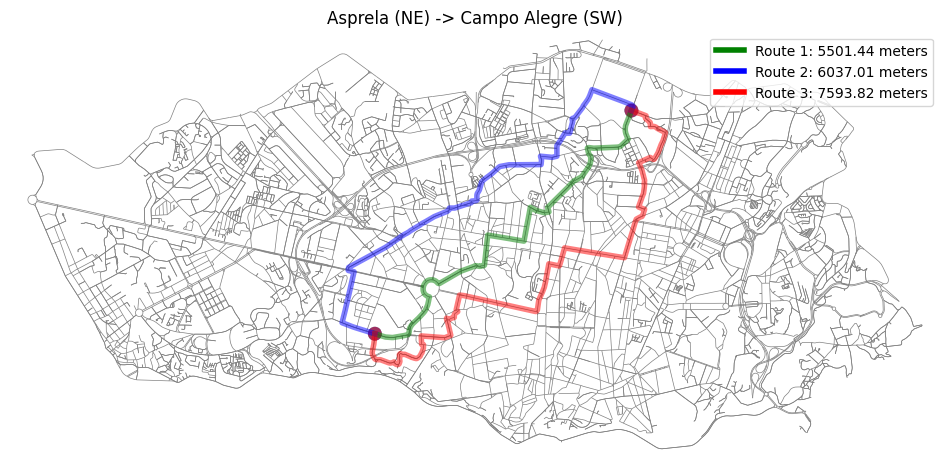

In [88]:
# Plot the base graph and routes on a single plot
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, ax=ax, show=False, close=False, node_size=0, edge_color='gray', edge_linewidth=0.5)
ox.plot_graph_routes(G, routes_a2c, ax=ax, route_colors=['green', 'blue', 'red'], route_linewidth=4, node_size=0, show=False, close=False)
plt.title("Asprela (NE) -> Campo Alegre (SW)")

# Add legend with route number and length
path_colors = ['green', 'blue', 'red']  # Colors for the routes
legend_elements = [
    plt.Line2D(
        [0], [0],
        color=color,
        lw=4,
        label=f"Route {i + 1}: {length:.2f} meters"
    )
    for i, (color, length) in enumerate(zip(path_colors, route_lengths_a2c))
]
ax.legend(handles=legend_elements, loc="upper right")

plt.show()

### Calculate routes Campo Alegre -> Asprela

In [89]:
# Compute 3 distinct routes
routes_c2a = compute_distinct_routes(G, campoalegre, asprela, num_routes=num_routes)

# Calculate and print lengths of routes
route_lengths_c2a = [calculate_route_length(G, route) for route in routes_c2a]

# Sort by length (shortest to longest)
sorted_routes = sorted(zip(routes_c2a, route_lengths_c2a), key=lambda x: x[1])
routes_c2a, route_lengths_c2a = zip(*sorted_routes)  # Unzip sorted pairs

# Print
print("Campo Alegre -> Asprela")
for i, length in enumerate(route_lengths_c2a, start=1):
    print(f"Route {i} length: {length:.2f} meters")

Campo Alegre -> Asprela
Route 1 length: 5486.20 meters
Route 2 length: 6671.41 meters
Route 3 length: 6984.89 meters


### Plot routes Campo Alegre -> Asprela

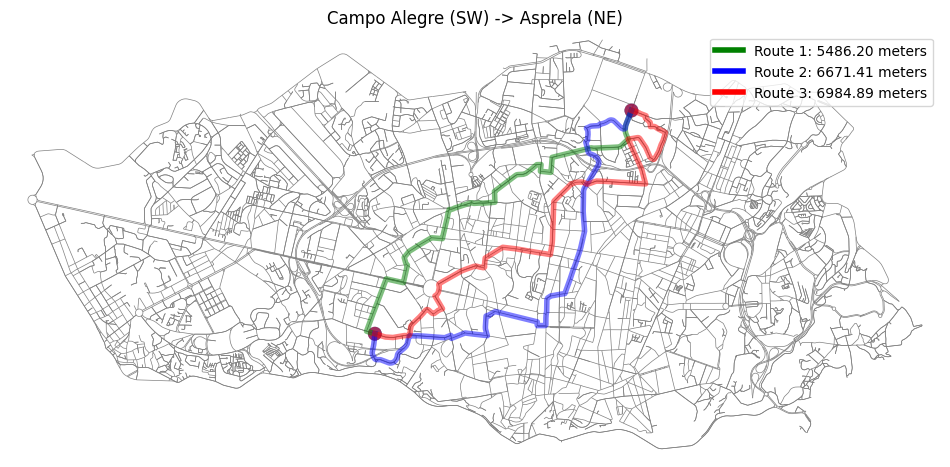

In [90]:
# Plot the base graph and routes on a single plot
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, ax=ax, show=False, close=False, node_size=0, edge_color='gray', edge_linewidth=0.5)
ox.plot_graph_routes(G, routes_c2a, ax=ax, route_colors=['green', 'blue', 'red'], route_linewidth=4, node_size=0, show=False, close=False)
plt.title("Campo Alegre (SW) -> Asprela (NE)")

# Add legend with route number and length
path_colors = ['green', 'blue', 'red']  # Colors for the routes
legend_elements = [
    plt.Line2D(
        [0], [0],
        color=color,
        lw=4,
        label=f"Route {i + 1}: {length:.2f} meters"
    )
    for i, (color, length) in enumerate(zip(path_colors, route_lengths_c2a))
]
ax.legend(handles=legend_elements, loc="upper right")

plt.show()

### Save routes to CSV

In [91]:
# Save all routes as CSVs
for i, route in enumerate(routes_a2c, start=1):
    save_route_as_csv(G, "Asprela_2_Campo_Alegre", route, route_id=i)
 
for i, route in enumerate(routes_c2a, start=1):
    save_route_as_csv(G, "Campo_Alegre_2_Asprela", route, route_id=i)

Asprela_2_Campo_Alegre Route 1 saved: 79 nodes, 118 edges
Asprela_2_Campo_Alegre Route 2 saved: 73 nodes, 102 edges
Asprela_2_Campo_Alegre Route 3 saved: 80 nodes, 118 edges
Campo_Alegre_2_Asprela Route 1 saved: 56 nodes, 82 edges
Campo_Alegre_2_Asprela Route 2 saved: 57 nodes, 78 edges
Campo_Alegre_2_Asprela Route 3 saved: 88 nodes, 141 edges


### Additional shenanigans

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx

# Function to generate a multi-index for extracting edge details
def generate_multiindex(route_nodes):
    multiindex_list = []
    # Create tuples of edges
    for u, v in zip(route_nodes[:-1], route_nodes[1:]):
        multiindex_list.append((u, v, 0))
    return multiindex_list

# Load the graph for Porto, Portugal
place = "Porto, Portugal"
G = ox.graph_from_place(place, network_type="drive")

# Origin and destination nodes (Asprela and Campo Alegre)
orig, dest = 4523960189, 479183608

# Find the top k-shortest paths
# fetch k shortest path
routes_nodes = ox.k_shortest_paths(G, orig, dest, k=1, weight="length")

# get edges from from above multidigraph
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# generate multiindex based on generated shortest route
routes_index_list = []
for route_nodes in routes_nodes:
    multiindex_list = generate_multiindex(route_nodes)
    routes_index_list.extend(multiindex_list)

# fetch edge details based on multi index list
shrt_gdf_edges = gdf_edges[gdf_edges.index.isin(routes_index_list)]
# plot the shortest route on map
shrt_gdf_edges.explore(color="red")
